In [1]:
# A veces necesitamos instalar nuevas librerías en nuestros proyectos
!pip install openpyxl==3.0.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 33.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# imports
import numpy as np
import pandas as pd
import sqlite3 as sql3
import openpyxl # levantar excel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick

<h2>Paso 1: Alcances del proyecto y obtener datos</h2>
<h3>Alcances del proyecto</h3>
<p>En este proyecto vamos a integrar tres sets de datos con lista de vendedores, lista de artículos y registro de operaciones de un mes, que nos ayudarán a responder tres preguntas: </p>
<ul>
<li>¿Cuál es el artículo más vendido? (unidades)</li>
<li>¿Qué artículo es el que más ingresos nos proporcionó?</li>
<li>¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</li>
<li>¿Hay grandes variaciones en ventas a lo largo del mes?</li>
</ul>
<p>Para este proyecto utilizaremos herramientas de Pandas para análisis exploratorio, Numpy para el análisis de ciertas columnas y Matplotlib/Seaborn para visualización de resultados.</p>

<h3>Descripción y obtención de los datos</h3>
<h4>Fuentes de datos</h4>
<ul>
<li>articles.db: BD con datos de los artículos.</li>
<li>sellers.xlsx: datos de los vendedores.</li>
<li>orders.csv: registro de las ventas de un mes.</li>
</ul>

In [3]:
# Levanto los datos en 3 diferentes dataframes

# Artículos
conn = sql3.connect('/work/articles.db')
sql_query = pd.read_sql_query('SELECT * FROM articles', conn)
df_articles = pd.DataFrame(sql_query, columns=['article_id', 'article_name', 'unit_price'])

# Vendedores
df_sellers = pd.read_excel('/work/sellers.xlsx', index_col=0)

# Órdenes
df_orders = pd.read_csv('/work/orders.csv')

<h2>Paso 2: Explorar y preparar los datos</h2>
<h3>Exploración</h3>

In [4]:
# Exploración del df de artículos
print('Muestra de datos')
print(df_articles.head()) # 5 Filas por defecto
print('\nFormato del dataframe')
print(df_articles.shape)
print('\nBúsqueda de valores null por columna')
print(df_articles.isnull().sum())
print('\nFormato de los datos por columna')
print(df_articles.dtypes)

Muestra de datos
   article_id article_name unit_price
0       20015   Smartphone     525.00
1       20016      Full Pc    2127.81
2       20017      Monitor     230.00
3       20018       Tablet     130.00
4       20019         Desk     130.10

Formato del dataframe
(31, 3)

Búsqueda de valores null por columna
article_id      0
article_name    0
unit_price      0
dtype: int64

Formato de los datos por columna
article_id       int64
article_name    object
unit_price      object
dtype: object


In [5]:
# Exploración del df de vendedores
print('Muestra de datos')
print(df_sellers.head()) # 5 Filas por defecto
print('\nFormato del dataframe')
print(df_sellers.shape)
print('\nBúsqueda de valores null por columna')
print(df_sellers.isnull().sum())
print('\nFormato de los datos por columna')
print(df_sellers.dtypes)

Muestra de datos
                 seller_name
seller_id                   
1           Aveline Swanwick
2                   Jase Doy
3          Oliviero Charkham
4           Cornie Wynrehame
5                Ewell Peres

Formato del dataframe
(15, 1)

Búsqueda de valores null por columna
seller_name    0
dtype: int64

Formato de los datos por columna
seller_name    object
dtype: object


In [6]:
# Exploración del df de órdenes
print('Muestra de datos')
print(df_orders.head()) # 5 Filas por defecto
print('\nFormato del dataframe')
print(df_orders.shape)
print('\nBúsqueda de valores null por columna')
print(df_orders.isnull().sum())
print('\nFormato de los datos por columna')
print(df_orders.dtypes)

Muestra de datos
   order_id  week  article_id  quantity  seller_id country_name
0     15024     1       20039        10         10         Peru
1     15025     1       20029        15          5         Peru
2     15026     1       20024         5         14      Bolivia
3     15027     1       20018         9         14       Brazil
4     15028     1       20035         6         15       Mexico

Formato del dataframe
(1000, 6)

Búsqueda de valores null por columna
order_id        0
week            0
article_id      0
quantity        0
seller_id       0
country_name    0
dtype: int64

Formato de los datos por columna
order_id         int64
week             int64
article_id       int64
quantity         int64
seller_id        int64
country_name    object
dtype: object


<h3>Preparación</h3>
<p>Encuentro un inconveniente en la columna de precios de los artículos. Necesito cambiar el formato cadena a float.</p>

In [7]:
# ** 'unit_price' era considerado como object **
df_articles['unit_price'] = df_articles['unit_price'].astype(float)
print(df_articles.dtypes)


article_id        int64
article_name     object
unit_price      float64
dtype: object


<h2>Paso 3: Definir el modelo de datos</h2>
<p>Crearemos un nuevo dataframe a partir de las fuentes de datos proporcionados.</p>
<img src='/work/modelo.png'>


<h2>Paso 4: Correr los pipelines para modelar los datos</h2>
<p>Llamamos pipeline a una serie de procesos en el cual la salida de un proceso es la entrada que utiliza el siguiente proceso.</p>

In [8]:
# Creo una copia del df_orders

my_df = df_orders.copy() # shallow copy o copia superficial


# Cambio el indice del df de artículos
df_articles.set_index('article_id', inplace=True) #inaplace=True para que los cambios se apliquen definitivamente sobre el set de datos original


my_df = my_df.assign(article_name = my_df['article_id'])
my_df = my_df.assign(total_amount = my_df['article_id'])
my_df = my_df.assign(seller_name = my_df['seller_id'])

# my_df

for i in range(max(my_df.count())):
    # print(i)

    # SINTAXIS: df_articles.loc[indice][columna]
    # [indice]: va a ser el dato que obtengo de [my_df.loc[i]['article_id']]
    # o sea, tomo registro por registro el article_id y lo uso para extraer el nombre del artículo (article_name) de df_articles
    # print(df_articles.loc[my_df.loc[i]['article_id']]['article_name'])

    article = df_articles.loc[my_df.loc[i]['article_id']]['article_name']
    # print(article)

    # Asignar a cada valor id de la columna 'article_name' (my_df) el nombre del artículo
    my_df.loc[i, 'article_name'] = article

# my_df

    # hacemos lo mismo con total_amount
    my_df.loc[i, 'total_amount'] = my_df.loc[i, 'quantity']*df_articles.loc[my_df.loc[i]['article_id']]['unit_price']


    # Columna de seller_name
    my_df.loc[i, 'seller_name'] = df_sellers.loc[my_df.loc[i]['seller_id']]['seller_name']


# Elimino las columnas que no necesito del df
my_df.drop(['order_id', 'article_id', 'seller_id'], axis='columns', inplace=True)
print(my_df)





     week  quantity country_name   article_name  total_amount      seller_name
0       1        10         Peru  Water Cooling         675.0  Cirilo Grandham
1       1        15         Peru          Mouse         454.5      Ewell Peres
2       1         5      Bolivia        Netbook         725.0   Janel O'Curran
3       1         9       Brazil         Tablet        1170.0   Janel O'Curran
4       1         6       Mexico           Case         227.4  Daisie Slograve
..    ...       ...          ...            ...           ...              ...
995     4         1       Brazil          Modem          67.5       Kati Innot
996     4        15       Brazil       Heatsink         150.0  Daisie Slograve
997     4         2     Colombia       Heatsink          20.0  Vasily Danilyuk
998     4        14       Brazil         Tablet        1820.0  Vasily Danilyuk
999     4        12       Brazil            SDD         264.0     Onida Cosely

[1000 rows x 6 columns]


In [9]:
#my_df.loc[:, 'quantity']
#my_df.loc[0, ['quantity' ,'country_name']]
#my_df.loc[0:5, ['quantity' ,'country_name']]
#my_df.iloc[:, 1]
#my_df.iloc[0, [1,2]]
my_df.iloc[0:6, [1,2]]

,quantity,country_name
0,10,Peru
1,15,Peru
2,5,Bolivia
3,9,Brazil
4,6,Mexico
5,6,Peru


<h2>Paso 5: Responder las preguntas</h2>


<h3>1. ¿Cuál es el artículo más vendido? (en unidades)</h3>

In [10]:
# RESOLUCIÓN ANALÍTICA

# print(my_df['article_name'].value_counts()) # cuenta valores únicos

# Si no filtro por 'quantity' toma las series numéricas
# df7 = my_df.groupby(by='article_name').sum().sort_values('quantity', ascending=False)
# print(df7.head())
# print(df7[['quantity']].head())
# print()

# Tomamos article_name como una columna más
# df7 = my_df.groupby(by='article_name').sum().sort_values('quantity', ascending=False).reset_index()
# print(df7.head())
# df7_2 = df7[['article_name', 'quantity']].groupby('article_name').sum('quantity').sort_values('quantity', ascending=False)
# print(df7_2.head())
# print()
# print(df7_2.head().index)
# print(df7_2.index[0]) # toma correctamente el index

# Vista tipo Serie
# df7 = my_df.groupby(by='article_name')['quantity'].sum().sort_values(ascending=False).head()
# df7 = my_df.groupby(by='article_name')[['quantity'] + ['total_amount']].sum().sort_values('quantity',ascending=False).head()
# print(df7)
# print(df7.head().index)

# Vista tipo Serie
# df7 = my_df.groupby(by='article_name')['quantity'].sum().sort_values(ascending=False)
# print(df7.iloc[0:5])

# Vista tipo Serie (reset index)
# df7 = my_df.groupby(by='article_name')['quantity'].sum().sort_values(ascending=False).reset_index()
# print(df7.iloc[0:5])

# Vista tipo Serie
# df7 = my_df.groupby(by='article_name')['quantity'].sum().sort_values(ascending=False)
# df7 = my_df.groupby(by='article_name').sum().sort_values('quantity', ascending=False)
# print(df7.loc['HDD':'Netbook'])
# print(df7.loc['HDD':'Netbook']['quantity'])
# print(df7.head())

# df7 = my_df.groupby(by='article_name').agg({'quantity':'sum'}).sort_values('quantity',ascending=False)
# print(df7.head())

# df7 = my_df.groupby(by='article_name').agg({'quantity':'sum'}).rename(columns={'quantity':'Cantidad'}).sort_values('Cantidad',ascending=False)
# print(df7.head())

# df7 = my_df.groupby(by='article_name').agg({'quantity':'sum'}).reset_index().rename(columns={'quantity':'Cantidad'}).sort_values('Cantidad',ascending=False)
# print(df7.head())

# df7 = my_df.groupby(by='article_name').sum().sort_values('quantity', ascending=False).head()
df7 = my_df.groupby(by='article_name').sum().sort_values('quantity', ascending=False)
pd.options.display.float_format= '$ {:,.2f}'.format
# print(df7[['quantity']].head())
print(df7[['quantity', 'total_amount']].head())
# print(df7[['quantity', 'total_amount']])


              quantity  total_amount
article_name                        
HDD                413   $ 22,558.06
Tablet             374   $ 48,620.00
SDD                372    $ 8,184.00
Mouse              322    $ 9,756.60
Netbook            320   $ 46,400.00


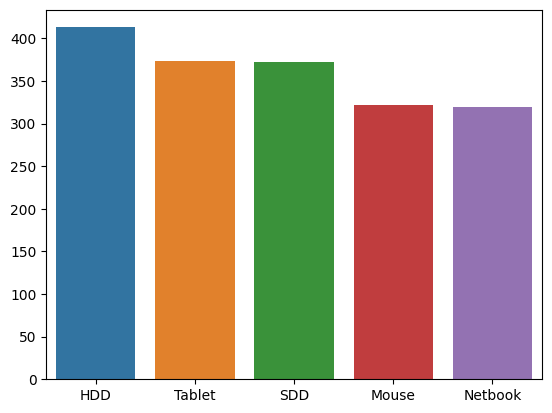

In [11]:
# RESOLUCIÓN GRÁFICA
# sns.barplot(data=df7, x=df7.index, y ='quantity')


# Opcion 2
xs = ['HDD', 'Tablet', 'SDD', 'Mouse', 'Netbook']
ys = [413, 374, 372, 322, 320]

sns.barplot(x=xs, y=ys)

plt.xticks(rotation='horizontal') # 'vertical'
plt.show()

<h3>2. ¿Qué artículo es el que más ingresos nos proporcionó?</h3>

In [12]:
# RESOLUCIÓN ANALÍTICA
df2 = my_df.groupby(by='article_name').sum().sort_values('total_amount', ascending=False).head(5)
pd.options.display.float_format= '$ {:,.2f}'.format
print(df2['total_amount'])

# 'article_name' es el index

# print()
# print(df2.index[0])

# print()
# print(df2.reset_index().iloc[0])

# print()
# for i in range(5):
#     print(df2.reset_index().iloc[i])
#     print()

print()
print(df2.reset_index())

article_name
Full Pc      $ 538,335.93
Notebook     $ 251,000.00
Smartphone   $ 152,250.00
Chair         $ 69,477.48
Tablet        $ 48,620.00
Name: total_amount, dtype: float64

  article_name  week  quantity  total_amount
0      Full Pc    70       253  $ 538,335.93
1     Notebook    69       251  $ 251,000.00
2   Smartphone    74       290  $ 152,250.00
3        Chair    56       207   $ 69,477.48
4       Tablet    90       374   $ 48,620.00


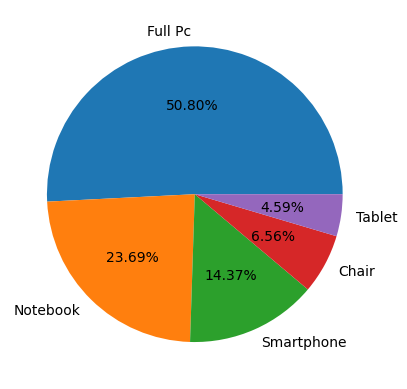

In [13]:
# RESOLUCIÓN GRÁFICA
plt.pie(x=df2['total_amount'], labels=df2.index, autopct='%1.2f%%')
plt.show()

<h3>3. ¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</h3>

In [14]:
# RESOLUCIÓN ANALÍTICA
df4 = my_df.groupby(by='seller_name').sum().sort_values('total_amount', ascending=False)
pd.options.display.float_format= '$ {:,.2f}'.format
print(df4[['quantity'] + ['total_amount']].head(5))

# 'seller_name' es el index

                   quantity  total_amount
seller_name                              
Janel O'Curran          703  $ 192,832.47
Brockie Patience        441  $ 142,709.88
Oliviero Charkham       555  $ 141,329.76
Vasily Danilyuk         521  $ 129,157.55
Daisie Slograve         554  $ 120,520.11


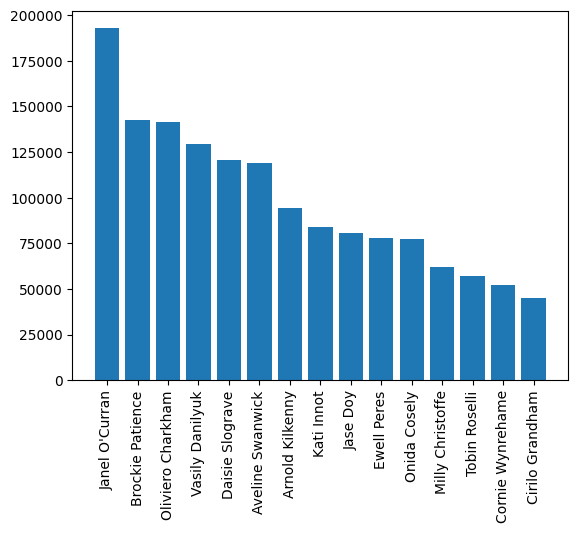

In [15]:
# RESOLUCIÓN GRÁFICA
plt.bar(df4.index, df4['total_amount'])
plt.xticks(rotation=90)
plt.show()

<h3>4. ¿Hay grandes variaciones en ventas a lo largo del mes?</h3>
<h4>Si es así, ¿en qué momento debería lanzar una campaña de promociones?</h4>


In [16]:
# RESOLUCIÓN ANALÍTICA
df5 = my_df.groupby(by='week').sum().sort_values('total_amount', ascending=False)
pd.options.display.float_format= '$ {:,.2f}'.format
print(df5[['quantity'] + ['total_amount']])

# 'week' es el index


      quantity  total_amount
week                        
1         2449  $ 507,458.81
2         2444  $ 415,364.44
3         2114  $ 329,140.03
4         1058  $ 223,844.56


[1 2 3 4] [507458.81 415364.44 329140.03 223844.56]


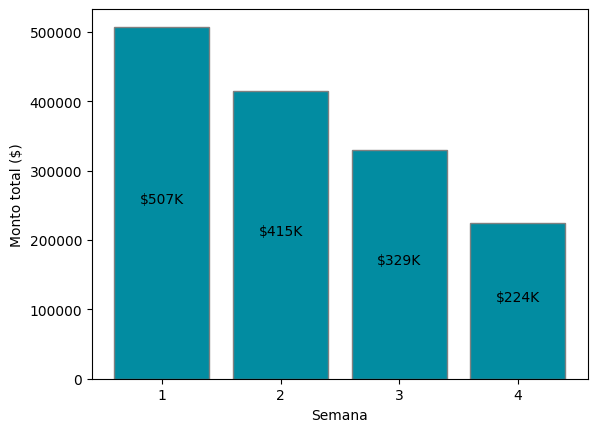

In [17]:
# RESOLUCIÓN GRÁFICA


fig = plt.figure()
ax = fig.add_subplot()
plt.bar(df5.index, df5['total_amount'], color='#028CA1', edgecolor='gray')
ax.xaxis.set_major_locator(tick.MultipleLocator(1))
# Esto significa que habrá una marca mayor para cada unidad en el eje x


def addlabels(x, y):
    print(x, y)
    for i in range(len(x)):
        etiqueta = '$' + str(round(int(y[i])/1000)) + 'K'
        plt.text(i + 1, y[i]//2, s=etiqueta, ha='center')


addlabels(df5.index.values, df5['total_amount'].values)

plt.xlabel('Semana')
plt.ylabel('Monto total ($)')
plt.show()
# 'week' es el index

<h2>Tareas a realizar</h2>
<ul>
<li>Pensar 3 preguntas y responderlas con el método que consideres más apropiado. Al menos una de ellas debe contener la columna 'country_name' y al menos una de ellas debe buscar correlación entre dos variables categóricas.</li>
<li>Personalizar, estilar y dar contexto a las gráficas.</li>
<li>Generar un informe en el que se responda en forma coloquial a las preguntas, agregando conclusiones y consejos que puedan surgir de este trabajo. Se pueden agregar imágenes.</li>
<li>Publicar el trabajo <a href="https://youtu.be/FCQRhs4dxls">https://youtu.be/FCQRhs4dxls</a></li>
</ul>

<h3>5. ¿Cuál es el artículo más vendido en Argentina y Colombia?</h3>

In [48]:
# RESOLUCIÓN
# Ventas filtrado por país. Comparar 2 países
# Cuál es el producto que más se vende, en qué cantidad

# Resolución Analítica

df_argentina =  my_df[my_df['country_name'] == 'Argentina']
df_arg_articulos = df_argentina.groupby(by='article_name').sum().sort_values('quantity', ascending=False)
df8 = df_arg_articulos.iloc[0:5]
df8



,week,quantity,total_amount
article_name,,,
CPU,23,104,"$ 14,520.48"
SDD,12,73,"$ 1,606.00"
HDD,18,68,"$ 3,714.16"
Range Extender,19,58,"$ 1,186.10"
Fan Cooler,13,47,$ 199.75


In [38]:
df_colombia = my_df[my_df['country_name'] == 'Colombia']
df_col_articulos = df_colombia.groupby(by='article_name').sum().sort_values('quantity', ascending=False)
df9 = df_col_articulos.iloc[0:5]
df9

,week,quantity,total_amount
article_name,,,
SDD,16,74,"$ 1,628.00"
Headphones,17,55,"$ 1,281.50"
Smartphone,13,52,"$ 27,300.00"
Webcam,7,52,"$ 1,043.64"
Usb Cable,16,51,$ 150.45


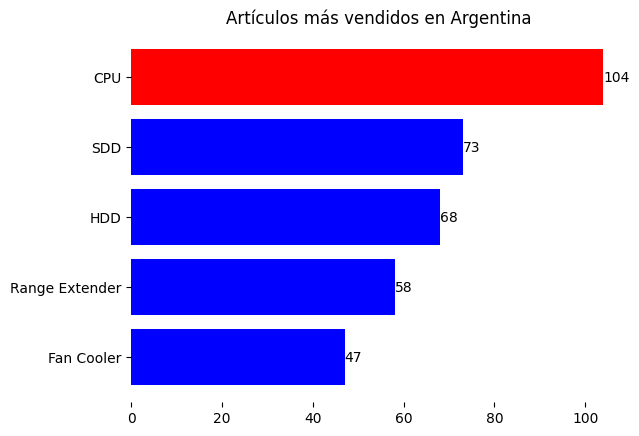

In [54]:
#Resolución gráfica

plt.barh(
    df8.index, 
    df8['quantity'], 
    color= ['red' if x in df8.index[0] else 'blue' for x in df8.index], 
    align='center', 
    edgecolor='none')
plt.gca().invert_yaxis()
plt.title('Artículos más vendidos en Argentina')
articulos = df8.index
cantidad = df8['quantity'].values
for i in range(len(articulos)):
    etiqueta = str(int(cantidad[i]))
    plt.text( s=etiqueta, x=cantidad[i] ,y=articulos[i], ha='left', va='center')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

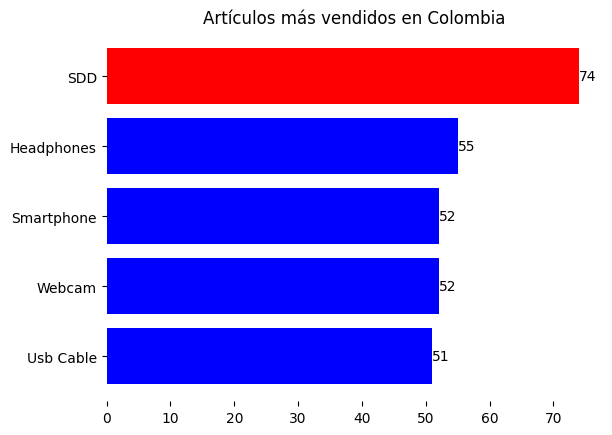

In [55]:
plt.barh(
    df9.index, 
    df9['quantity'], 
    color= ['red' if x in df9.index[0] else 'blue' for x in df9.index], 
    align='center', 
    edgecolor='none')
plt.gca().invert_yaxis()
plt.title('Artículos más vendidos en Colombia')
articulos = df9.index
cantidad = df9['quantity'].values
for i in range(len(articulos)):
    etiqueta = str(int(cantidad[i]))
    plt.text( s=etiqueta, x=cantidad[i] ,y=articulos[i], ha='left', va='center')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

<h3>6. Pregunta</h3>

In [19]:
# RESOLUCIÓN
# Evolución de Ventas por producto.
# Tomar 2 países y 'week' como variable categórica
# Resolución Analítica y Gráfica

<h3>7. Pregunta </h3>

In [20]:
# RESOLUCIÓN
# Mejor vendedor. Mostrar importe. Comparar 2 países (variable categórica)
# Resolución Analítica y Gráfica

<h2>Conclusiones y propuestas</h2>

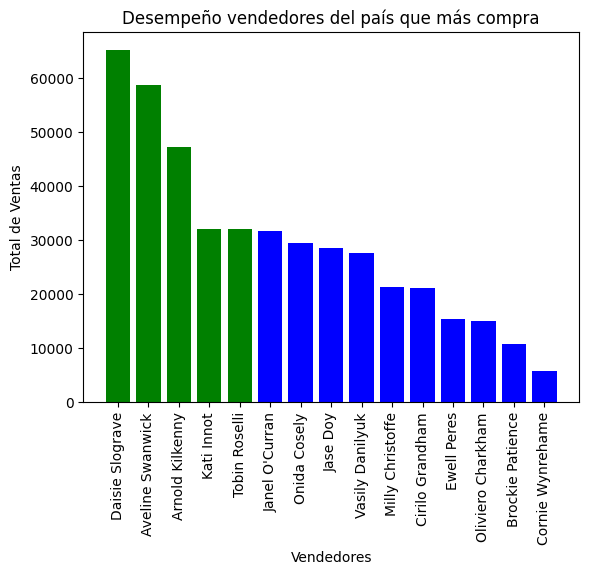

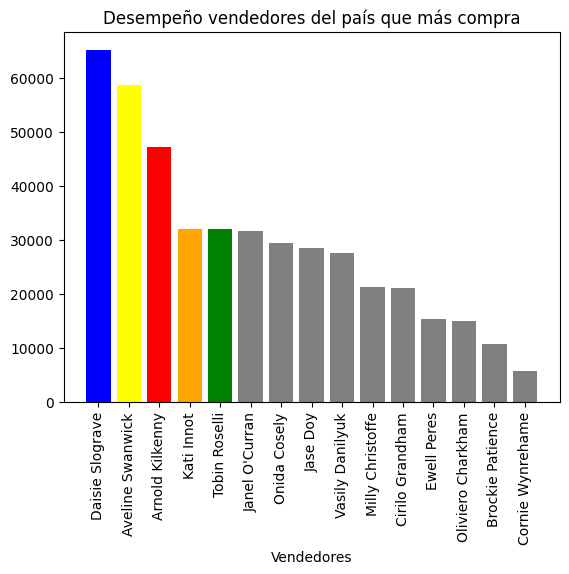

In [21]:
# Resolucion Analitica
df6 = my_df[my_df['country_name'] == 'Brazil']
vendedores_pais = df6.groupby('seller_name').sum().sort_values('total_amount', ascending=False)
vendedores_pais.head()


# Opción Original

plt.bar(vendedores_pais.index,vendedores_pais['total_amount'], 
    color = ['green' if x in vendedores_pais.index[0:5] else 'blue' for x in vendedores_pais.index]) #Color verde para los mejores 5
plt.xticks(rotation = 90)
plt.title("Desempeño vendedores del país que más compra")
plt.xlabel("Vendedores")
plt.ylabel("Total de Ventas")
plt.show()

# Segunda Opción 

x = np.arange(15)

c = []
for values in x:
    if values == 0:
        c.append('blue')
    elif values == 1:
        c.append('yellow')
    elif values == 2:
        c.append('red')
    elif values == 3:
        c.append('orange')
    elif values == 4:
        c.append('green') 
    else:
        c.append('gray')

# print(c)

vendedores_pais.reset_index(inplace=True)

plt.bar(vendedores_pais['seller_name'],vendedores_pais['total_amount'], 
#     color = ['green' if x in vendedores_pais.index[0:5] else 'blue' for x in vendedores_pais.index]
# color= ["red" if x in vendedores_pais.index[0:1] else "lightgreen" if x in vendedores_pais.index[1:3] else "lightgray" for x in vendedores_pais.index])
    color = c) #Color verde para los mejores 5
plt.xticks(rotation = 90)
plt.title("Desempeño vendedores del país que más compra")
plt.xlabel("Vendedores")
# plt.ylabel("Total de Ventas")
plt.show()

                   total_amount  quantity
seller_name                              
Daisie Slograve     $ 65,283.28       226
Aveline Swanwick    $ 58,771.48       227
Arnold Kilkenny     $ 47,243.54       184
Kati Innot          $ 32,087.32       151
Tobin Roselli       $ 31,997.93       211
Janel O'Curran      $ 31,562.86       182
Onida Cosely        $ 29,354.31       206
Jase Doy            $ 28,493.25       149
Vasily Danilyuk     $ 27,495.77       124
Milly Christoffe    $ 21,247.38       161
Cirilo Grandham     $ 21,061.74       158
Ewell Peres         $ 15,253.22        91
Oliviero Charkham   $ 14,951.72       195
Brockie Patience    $ 10,756.96       125
Cornie Wynrehame     $ 5,711.09       125

                   total_amount
seller_name                    
Daisie Slograve     $ 65,283.28
Aveline Swanwick    $ 58,771.48
Arnold Kilkenny     $ 47,243.54
Kati Innot          $ 32,087.32
Tobin Roselli       $ 31,997.93
Janel O'Curran      $ 31,562.86
Onida Cosely        $ 29,354.

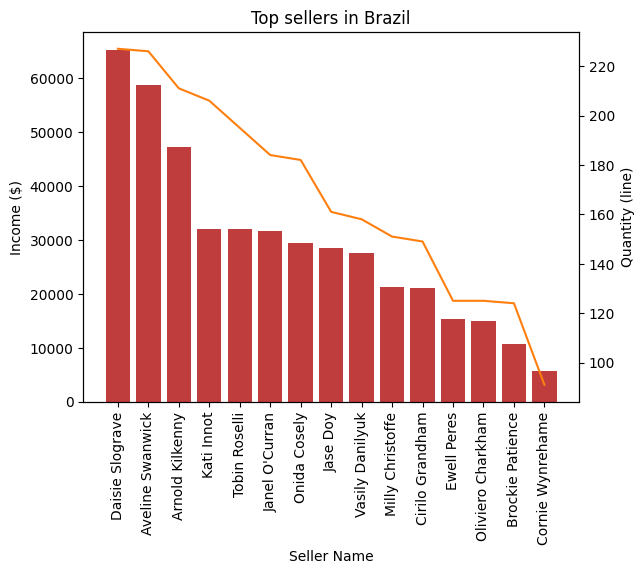

In [22]:
df_brazil = my_df[my_df['country_name'] == 'Brazil']

print(df_brazil[['seller_name','total_amount', 'quantity']].groupby('seller_name').sum().sort_values('total_amount', ascending=False))

print()
df_brazil_bars = df_brazil[['seller_name','total_amount']].groupby('seller_name').sum('total_amount').sort_values('total_amount', ascending=False)
print(df_brazil_bars)
print()
df_brazil_line = df_brazil[['seller_name','quantity']].groupby('seller_name').sum('quantity').sort_values('quantity', ascending=False).reset_index()
print(df_brazil_line)

fig, ax1 = plt.subplots()
# ax1: axes1

# sns.barplot(data = df_brazil_bars, x='seller_name', y='total_amount', ax=ax1,  color='C3')
sns.barplot(data = df_brazil_bars, x = df_brazil_bars.index, y='total_amount', ax=ax1,  color='C3')
# ax: axes
plt.xticks(rotation=90)
ax2 = ax1.twinx()
# ax2: axes2 = ax1.twinx()

sns.lineplot(data = df_brazil_line, x='seller_name', y='quantity', ax=ax2, color='C11')

plt.xticks(rotation=90)
plt.title('Top sellers in Brazil')

ax1.set_xlabel("Seller Name")

ax1.set_ylabel("Income ($)")
ax2.set_ylabel("Quantity (line)")

plt.show()

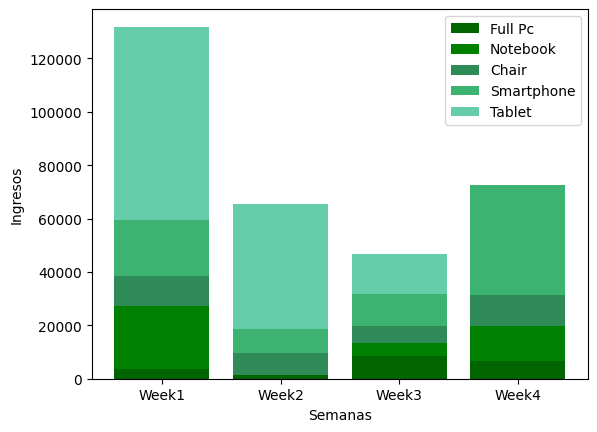

In [23]:
x1=['Week1', 'Week2', 'Week3', 'Week4']
L1=['Full Pc', 'Notebook','Chair', 'Smartphone', 'Tablet'] 

y1=np.array([72346, 46812, 14895, 0])
y2=np.array([21000, 9000, 12000, 41000])
y3=np.array([11412, 8055, 6377, 11747])
y4=np.array([23625, 0, 4725, 13125])
y5=np.array([3510, 1560, 8580, 6630])

plt.bar(x1,y5,color='darkgreen')
plt.bar(x1,y4, bottom=y5, color='green')
plt.bar(x1,y3, bottom=y5+y4, color='seagreen')
plt.bar(x1,y2,bottom=y5+y4+y3, color='mediumseagreen')
plt.bar(x1,y1, bottom=y5+y4+y3+y2, color='mediumaquamarine')

plt.xlabel('Semanas')
plt.ylabel('Ingresos')

plt.legend(L1)
plt.show()

                   quantity  total_amount
seller_name                              
Janel O'Curran          703  $ 192,832.47
Brockie Patience        441  $ 142,709.88
Oliviero Charkham       555  $ 141,329.76
Vasily Danilyuk         521  $ 129,157.55
Daisie Slograve         554  $ 120,520.11


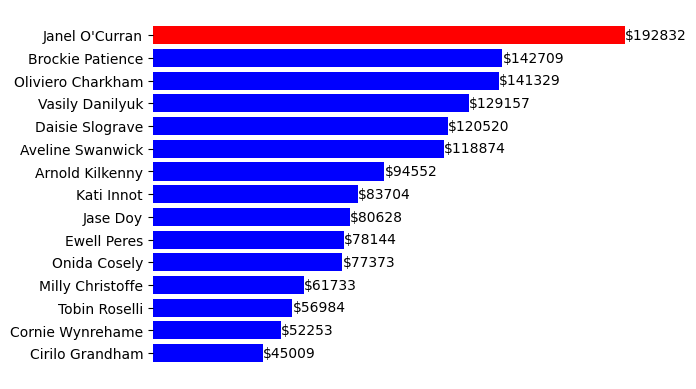

In [24]:
df4 = my_df.groupby(by='seller_name').sum().sort_values('total_amount', ascending=False)
pd.options.display.float_format = '$ {:,.2f}'.format
print(df4[['quantity'] + ['total_amount']].head(5))

plt.barh(df4.index, df4['total_amount'], align='center', color = ['red' if x in df4.index[0] else 'blue' for x in df4.index], edgecolor='none')

vendedores = df4.index
cantidad = df4['total_amount'].values

for i in range(len(vendedores)):
    etiqueta = '$' + str(int(cantidad[i]))
    plt.text( s=etiqueta, x=cantidad[i] ,y=vendedores[i], ha='left', va='center')

plt.gca().spines['bottom'].set_visible(False) # Borde inferior del gráfico no sea visible
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis() # se invierte el eje 'y', y los valores aumentan/disminuyen de arriba hacia abajo.

plt.xlabel('') # Nombre del Eje x es una cadena vacía
plt.xticks([]) # No muestra etiqueta Eje x
plt.ylabel('') # Nombre del Eje y es una cadena vacía

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=130acbc1-8473-4fa2-b8b3-889d1ffcead4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>